In [136]:
# import 
import networkx as nx
import osmnx as ox
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import LineString

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from matplotlib import pyplot as plt

In [137]:
# predefined
city = 'london'

#### 路网

In [138]:
links = pd.read_csv("UTD19/links.csv").query("citycode == @city")


In [139]:
def agg_func(df):
    xy = df.sort_values("order").loc[:,["long","lat"]].values
    df_out = df.iloc[0,:][["piece","linkid","group"]]
    df_out["geometry"] = LineString(xy)
    return df_out

links_gdf = links.groupby('linkid').apply(agg_func)
links_gdf = gpd.GeoDataFrame(links_gdf,geometry=links_gdf["geometry"],crs="EPSG:4326")


In [140]:
links_gdf.head(3)


,piece,linkid,group,geometry
linkid,,,,
0,1,0,0.1,"LINESTRING (-0.07375 51.50912, -0.07378 51.508..."
1,1,1,1.1,"LINESTRING (-0.07767 51.50225, -0.07767 51.502..."
2,1,2,2.1,"LINESTRING (-0.07763 51.50224, -0.07762 51.502..."


#### 检测器

In [141]:
# 检测器数据
detectors = pd.read_csv("UTD19/detectors_public.csv").query("citycode == @city")
detectors_gdf = gpd.GeoDataFrame(detectors,geometry=gpd.points_from_xy(detectors.long,detectors.lat),crs="EPSG:4326")

In [142]:
detectors_gdf.head(3)

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat,geometry
4856,EAST_N04/161x1,0.303585,0.261157,secondary,Homerton Road,NaN,london,1.0,5082.0,-0.021497,51.550929,POINT (-0.02150 51.55093)
4857,EAST_N04/161y1,0.103679,0.063417,primary,Eastway,NaN,london,1.0,5091.0,-0.020899,51.550704,POINT (-0.02090 51.55070)
4858,EAST_N04/162a1,0.260623,0.117906,secondary,Homerton Road,NaN,london,1.0,5083.0,-0.022649,51.550907,POINT (-0.02265 51.55091)


In [143]:
# 检测器个数
pd.read_csv("UTD19/detectors_public.csv").citycode.value_counts().head(5)

citycode
london         5719
tokyo          1887
losanageles    1725
melbourne      1630
madrid         1116
Name: count, dtype: int64

##### 可视化

ValueError: aspect must be finite and positive 

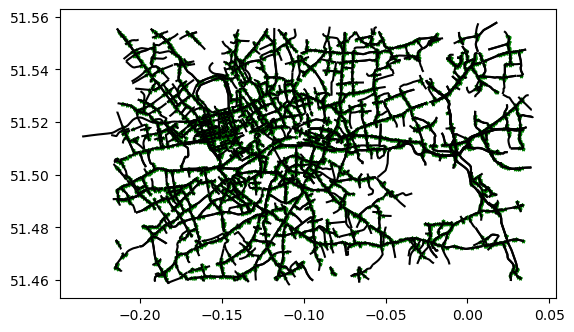

In [144]:
# 路网
fig,ax = plt.subplots()
detectors_gdf.plot(ax=ax,color='g',marker="*",markersize=5)
links_gdf.plot(ax=ax,color='k')
detectors_gdf.query("detid == 'K2D14'").plot(ax=ax,color='r')

<Axes: >

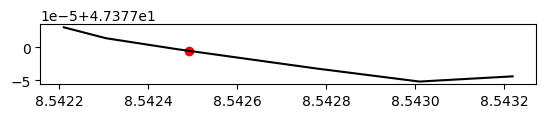

In [ ]:
# 路段
fig,ax = plt.subplots()
detectors_gdf.linkid.value_counts()
probe_linkid = [3]
links_gdf.query("linkid in @probe_linkid").plot(ax=ax,color="k")
detectors_gdf.query("linkid in @probe_linkid").plot(ax=ax,color="r")


In [ ]:
detectors_gdf.linkid.value_counts()

linkid
1128.0    1
808.0     1
297.0     1
690.0     1
689.0     1
         ..
554.0     1
553.0     1
552.0     1
551.0     1
1207.0    1
Name: count, Length: 1020, dtype: int64

#### 检测器数据

In [ ]:
probe_det = "K2D14"

In [83]:
measurements = pd.read_csv("UTD19/utd19_u.csv",dtype={"detid":str}).query("city == @city")

In [85]:
print(measurements.head(3))
print(measurements.detid.value_counts().head(3))


                  day  interval   detid  flow       occ  error    city  speed
130955369  2015-10-26       180  K10D11  40.0  0.005556    0.0  zurich    NaN
130955370  2015-10-26       360  K10D11   0.0  0.000000    0.0  zurich    NaN
130955371  2015-10-26       540  K10D11  40.0  0.007778    0.0  zurich    NaN
detid
K10D11     3359
K448D16    3359
K445D14    3359
Name: count, dtype: int64


In [88]:
measurements.query("detid == @probe_det").day.value_counts()

day
2015-10-27    480
2015-10-28    480
2015-10-29    480
2015-10-30    480
2015-10-31    480
2015-11-01    480
2015-10-26    479
Name: count, dtype: int64

In [95]:
m = measurements.query("detid == @probe_det and day == '2015-10-30'")

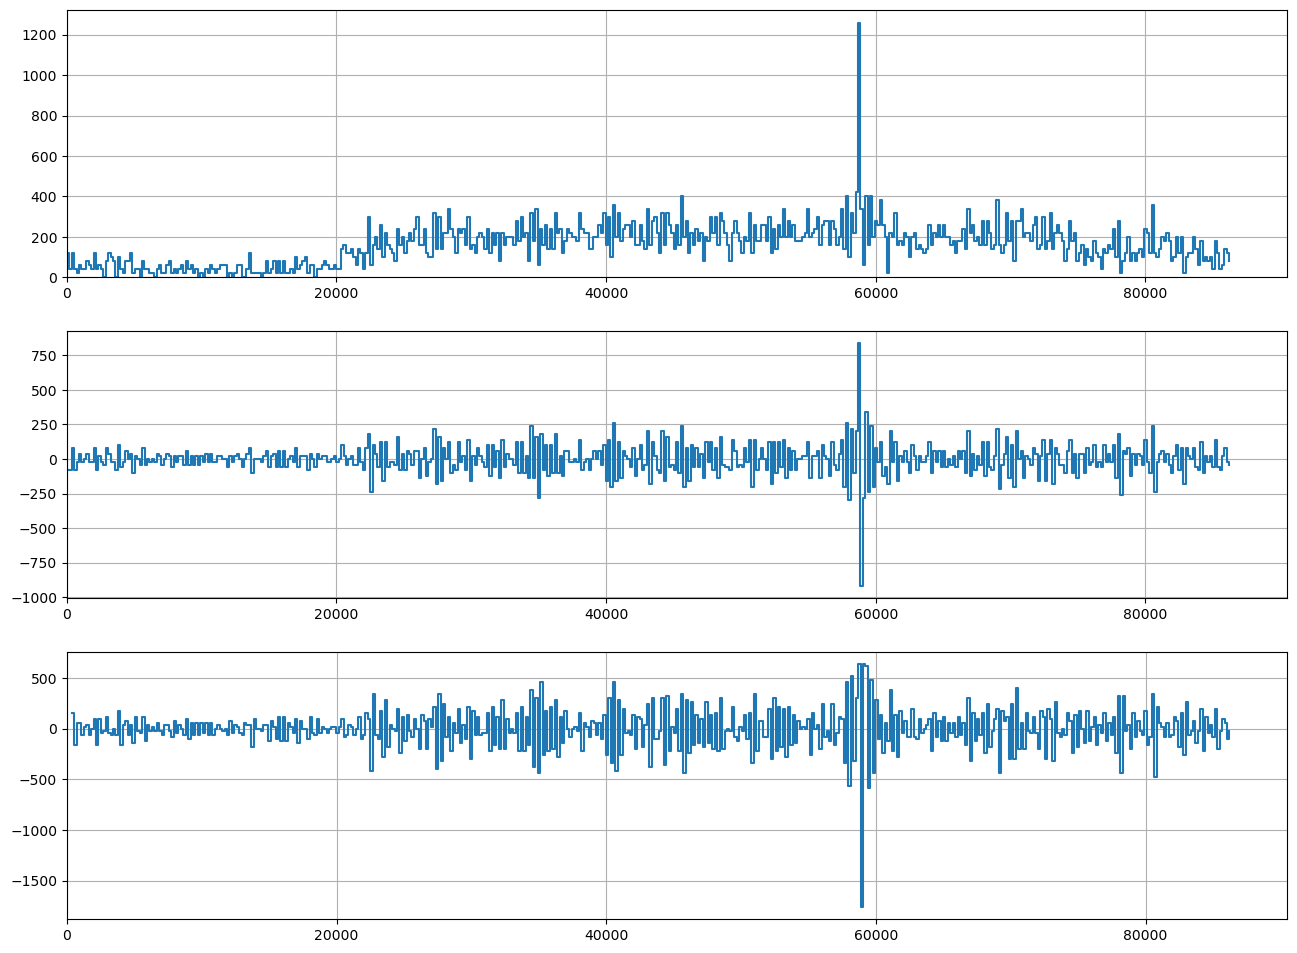

In [96]:
# flow
fig,axs = plt.subplots(3,1)
axs[0].step(m.interval,m.flow,where='post')
axs[0].set_ylim([0,None])
axs[0].set_xlim([0,None])
axs[0].grid()

axs[1].step(m.interval,m.flow.diff(1),where='post')
axs[1].set_xlim([0,None])
axs[1].grid()

axs[2].step(m.interval,m.flow.diff(1).diff(1),where='post')
axs[2].set_xlim([0,None])
axs[2].grid()

fig.set_size_inches(40/2.54,30/2.54)


In [99]:
# tsa
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(m.flow.diff(1).dropna(),lags=[i for i in range(1,6)],boxpierce=True)  # 差分后会出现nan，需要去除

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,149.525654,2.201109e-34,148.593062,3.519592e-34
2,156.899649,8.504994e-35,155.905735,1.397976e-34
3,164.871272,1.628476e-35,163.794492,2.780963e-35
4,168.702273,1.985986e-35,167.577705,3.461804e-35
5,172.856909,1.792517e-35,171.671879,3.208926e-35


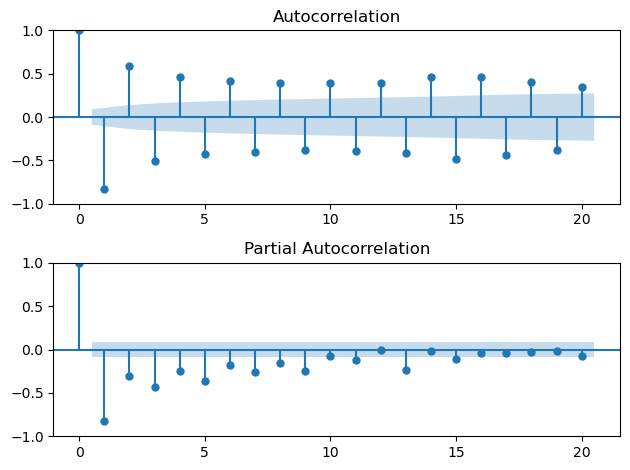

In [85]:
fig,axs = plt.subplots(2,1)
_ = sm.graphics.tsa.plot_acf(m.flow.diff(1).dropna(),lags=20,ax=axs[0])
_ = sm.graphics.tsa.plot_pacf(m.flow.diff(1).dropna(),lags=20,ax=axs[1])
fig.tight_layout()

In [ ]:
# smoothen
# exponential
def rwes(array):
    pass
# fourier
def fs(array):
    pass

(0.0, 90531.0)

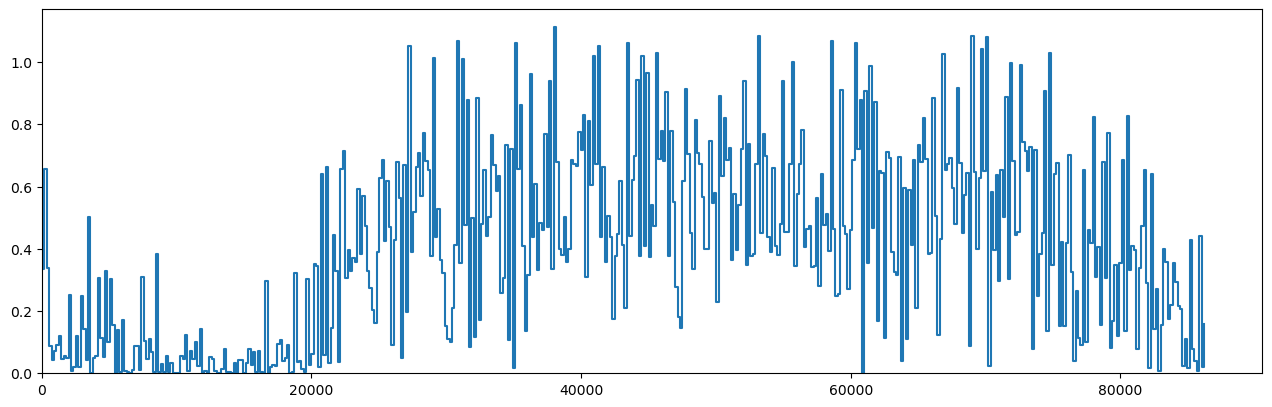

In [97]:
# occ
fig,ax = plt.subplots()
ax.step(m.interval,m.occ,where='post')
fig.set_size_inches(40/2.54,12/2.54)
ax.set_ylim([0,None])
ax.set_xlim([0,None])

(0.0, 90531.0)

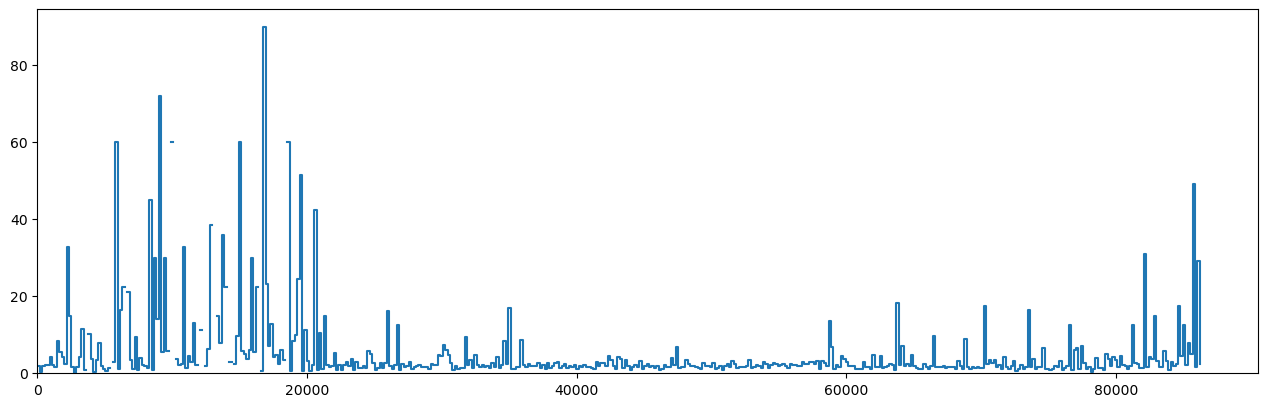

In [98]:
# speed
fig,ax = plt.subplots()
ax.step(m.interval,m.flow/((m.occ)/0.005),where='post')
fig.set_size_inches(40/2.54,12/2.54)
ax.set_ylim([0,None])
ax.set_xlim([0,None])

##### *tokyo检测器记录缺失

In [11]:
print(pd.read_csv("UTD19/detectors_public.csv").citycode.value_counts().shape)
print(pd.read_csv("UTD19/links.csv").citycode.value_counts().shape)
print(measurements.city.value_counts().shape)

(40,)
(40,)
(39,)
